# classifications avec TF

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset_path = "/content/drive/MyDrive/MASTER IA/exercices IA/"

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np


# Vérifier la version de TensorFlow
print(f"TensorFlow version: {tf.__version__}")



TensorFlow version: 2.18.0


In [ ]:
# pour le premier dataset (format h5py)
from utilities import *
X_train, y_train, X_test, y_test = load_data()

# Normalisation des données
X_train = X_train / 255.0
X_test = X_test / 255.0

# Affichage de quelques informations sur les données
print(f"Shape des données d'entraînement: {X_train.shape}")
print(f"Shape des données de test: {X_test.shape}")

# Visualisation de quelques images
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {'Chat' if y_train[i] == 0 else 'Chien'}")
    plt.axis('off')
plt.show()


In [ ]:
if len(X_train.shape) == 3:
    X_train = X_train[..., np.newaxis]  # Ajoute un canal pour les images en niveaux de gris
    X_test = X_test[..., np.newaxis]
# Affichons la forme de nos données
print("Forme de X_train:", X_train.shape)

In [4]:
#exercice de pré processing pour préparer mes images (format jpg)
#test sur une image d'abord
from PIL import Image
from numpy import asarray
image = Image.open(dataset_path+'cat_vs_dog_datasets/training_set/cats/cat.2.jpg')

img_matrix = asarray(image)

# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

print(img_matrix.shape) #c'est la shape RGB ou pas? jsuis pas sur (353, 405, 3)

JPEG
(312, 396)
RGB
(396, 312, 3)


In [10]:
import os
from tqdm import tqdm  # Pour afficher une barre de progression

def charger_dataset(dossier_base, taille=(128, 128)):
    categories = ['cats', 'dogs']  # Vos sous-dossiers
    X = []  # Pour stocker les images
    y = []  # Pour stocker les étiquettes (0: chat, 1: chien)

    for idx, categorie in enumerate(categories):
        chemin_categorie = os.path.join(dossier_base, categorie)
        print(f"Chargement des images de {categorie}...")

        # Liste tous les fichiers dans le dossier
        fichiers = os.listdir(chemin_categorie)

        # Parcours avec barre de progression
        for fichier in tqdm(fichiers):
            if fichier.endswith(('.jpg', '.jpeg', '.png')):
                chemin_image = os.path.join(chemin_categorie, fichier)

                try:
                    # Ouvrir l'image
                    image = Image.open(chemin_image)

                    # Redimensionner
                    image = image.resize(taille)

                    # Convertir en array numpy
                    image_array = np.array(image)

                    # Vérifier si l'image est en RGB (3 canaux)
                    if len(image_array.shape) == 3 and image_array.shape[2] == 3:
                        # Ajouter l'image et son étiquette aux listes
                        X.append(image_array)
                        y.append(idx)  # 0 pour chat, 1 pour chien
                    else:
                        print(f"Image ignorée (pas en RGB): {chemin_image}")

                except Exception as e:
                    print(f"Erreur avec l'image {chemin_image}: {e}")

    # Convertir en arrays numpy
    X = np.array(X)
    y = np.array(y)

    # Mélanger les données
    indices = np.random.permutation(len(X))
    X = X[indices]
    y = y[indices]
    return X, y

# Utilisation
X_train, y_train = charger_dataset(dataset_path+'cat_vs_dog_datasets/training_set')
X_test, y_test = charger_dataset(dataset_path+'cat_vs_dog_datasets/test_set')

# Normalisation
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")

Chargement des images de cats...


100%|██████████| 4000/4000 [01:14<00:00, 53.37it/s] 


Chargement des images de dogs...


100%|██████████| 4000/4000 [01:15<00:00, 52.99it/s] 


Chargement des images de cats...


100%|██████████| 1000/1000 [00:12<00:00, 82.25it/s]


Chargement des images de dogs...


100%|██████████| 1000/1000 [00:12<00:00, 77.50it/s]


Shape de X_train: (8000, 128, 128, 3)
Shape de y_train: (8000,)


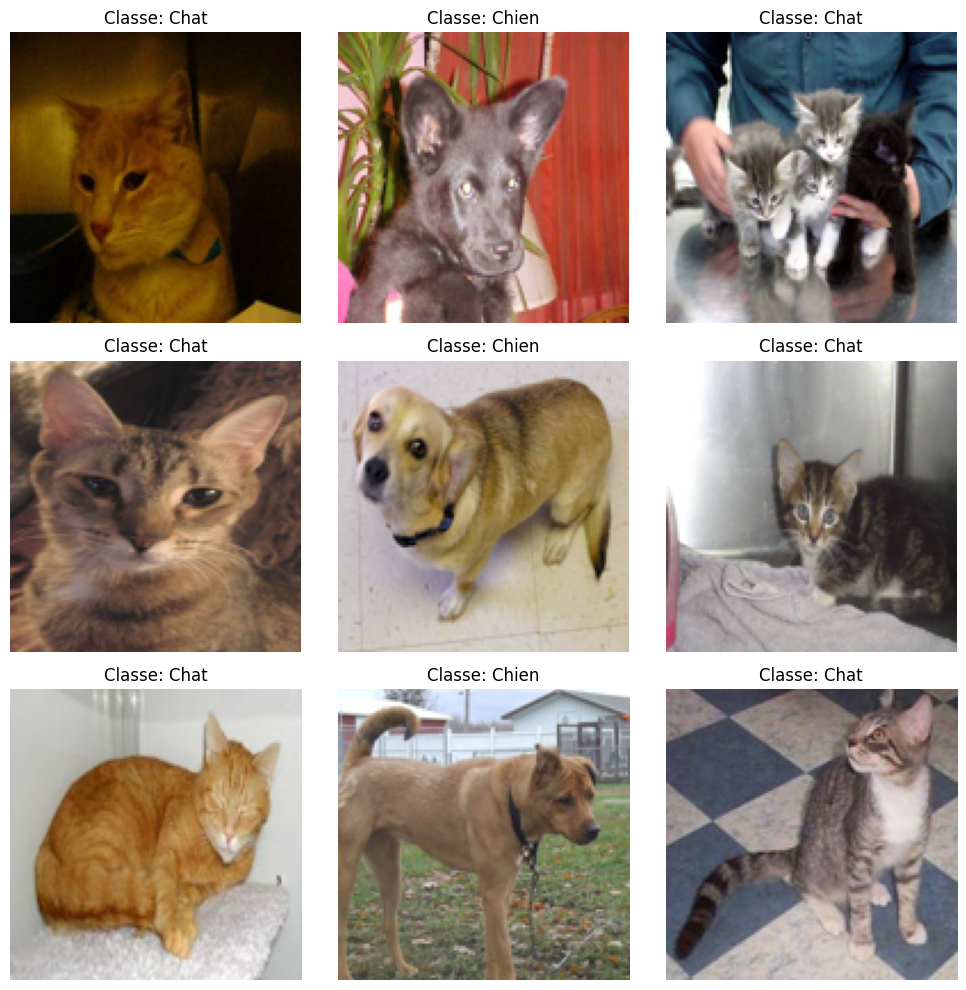

In [11]:
import matplotlib.pyplot as plt

   # Afficher quelques images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Classe: {'Chat' if y_train[i]==0 else 'Chien'}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from tensorflow.keras.regularizers import l2

In [39]:

# Avant le modèle.fit()
data_augmentation = Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomContrast(0.1),  # Variation de contraste
    tf.keras.layers.RandomBrightness(0.2)  # Variation de luminosité

])


# Création du modèle CNN avec explications
model = Sequential([
    data_augmentation,
    # Première couche de convolution
    # 32 : nombre de filtres (détecteurs de caractéristiques)
    # (3, 3) : taille de la fenêtre de convolution
    # activation='relu' : fonction d'activation qui garde les valeurs positives
    # input_shape : forme de nos images (hauteur, largeur, canaux)
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01), input_shape=(128, 128, 3)),
    # Réduction de la dimension spatiale par 2
    MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),


    # Deuxième couche de convolution : plus de filtres pour détecter des motifs plus complexes
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01),),
    MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),


    # Troisième couche de convolution : encore plus de filtres
    Conv2D(32, (3, 3), activation='relu',  padding='same',  kernel_regularizer=l2(0.01), ),
    MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    # Aplatissement : transformation de la matrice 3D en vecteur 1D
    Flatten(),

    # C'est ici que se fait la "prise de décision"
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),

    # Dropout : désactive aléatoirement 50% des neurones pendant l'entraînement
    # Cela évite le surapprentissage
    Dropout(0.1),

    # Couche de sortie : 1 neurone avec sigmoid pour la classification binaire
    # sigmoid donne une probabilité entre 0 (chat) et 1 (chien)
    Dense(1, activation='sigmoid')
])
# Affichage de l'architecture du modèle
# model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0000001)

# Configuration du modèle
model.compile(
    optimizer=optimizer,  # Algorithme d'optimisation adaptatif
    loss='binary_crossentropy',  # Fonction de perte pour classification binaire
    metrics=['accuracy']  # Mesure de la précision
)
#voir ce qui peut etre intéréssant à approfondir aux niveaux de l'optimizer et des metrics aussi

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.5139 - loss: 14.2682 - val_accuracy: 0.4890 - val_loss: 14.2062
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.4932 - loss: 14.2415 - val_accuracy: 0.4795 - val_loss: 14.1922
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.5072 - loss: 14.2096 - val_accuracy: 0.4985 - val_loss: 14.1809
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.5085 - loss: 14.1827 - val_accuracy: 0.4985 - val_loss: 14.1622
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5047 - loss: 14.1640 - val_accuracy: 0.4975 - val_loss: 14.1402
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5089 - loss: 14.1436 - val_accuracy: 0.4905 - val_loss: 14.1180
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.5023 - loss: 14.1251 - val_accuracy: 0.4935 - val_loss: 14.0955
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5114 - loss: 

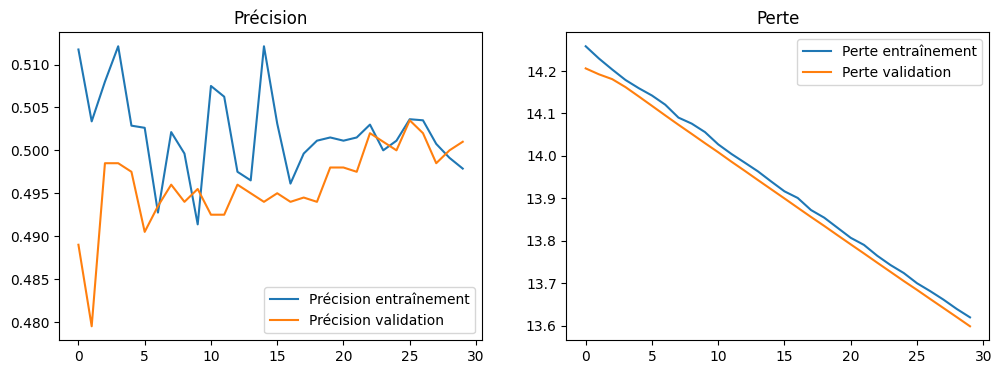

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    shuffle=True,  # Mélange les données à chaque époque
    callbacks=[early_stopping],
    verbose=1
)

# Visualisation des résultats
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Précision entraînement')
plt.plot(epochs_range, val_acc, label='Précision validation')
plt.legend()
plt.title('Précision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perte entraînement')
plt.plot(epochs_range, val_loss, label='Perte validation')
plt.legend()
plt.title('Perte')

plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.8320 - loss: 0.8142

Précision sur les données de test: 0.7545
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


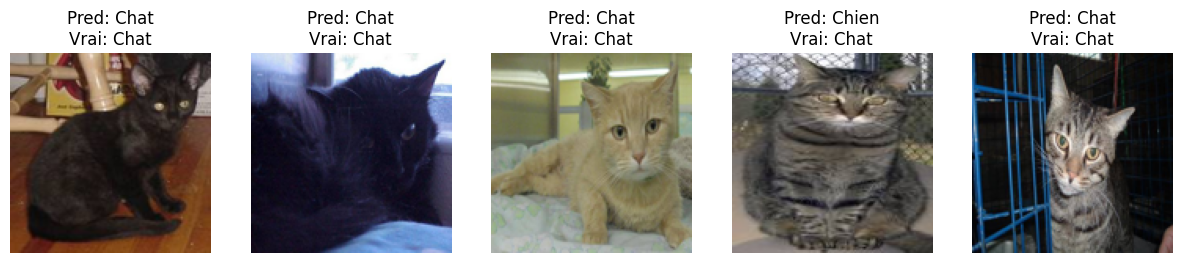

In [11]:
# Évaluation sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nPrécision sur les données de test: {test_accuracy:.4f}")

# Prédictions sur quelques images de test
predictions = model.predict(X_test[:5])

# Affichage des prédictions
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[i])
    pred = 'Chien' if predictions[i] > 0.5 else 'Chat'
    true = 'Chien' if y_test[i] == 1 else 'Chat'
    plt.title(f'Pred: {pred}\nVrai: {true}')
    plt.axis('off')
plt.show()

# Sauvegarde du modèle
# model.save('cat_vs_dog_model.h5')